In [116]:
import librosa
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, LayerNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
import matplotlib.pyplot as plt

In [4]:
def make_key_invariant_chromagram(y, sr):
    # Compute the chromagram
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=24)
    
    # Calculate the chroma values to determine the key
    chroma_vals = [np.sum(chromagram[i]) for i in range(12)]
    pitches = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    keyfreqs = {pitches[i]: chroma_vals[i] for i in range(12)}
    
    # Define major and minor profiles for key correlation
    maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    
    # Compute correlations for all keys
    maj_key_corrs = [np.corrcoef(maj_profile, [keyfreqs.get(pitches[(i + m) % 12]) for m in range(12)])[1,0] for i in range(12)]
    min_key_corrs = [np.corrcoef(min_profile, [keyfreqs.get(pitches[(i + m) % 12]) for m in range(12)])[1,0] for i in range(12)]
    keys = [p + ' major' for p in pitches] + [p + ' minor' for p in pitches]
    key_corrs = dict(zip(keys, maj_key_corrs + min_key_corrs))
    
    # Identify the key with the highest correlation
    key = max(key_corrs, key=key_corrs.get)
    
    # Determine tonic index and make chromagram key-invariant
    tonic = key.split()[0]
    tonic_index = pitches.index(tonic)
    key_invariant_chromagram = np.roll(chromagram, -tonic_index, axis=0)
    
    return key_invariant_chromagram


def find_anchor_frame(beats, tempo, sr):
    # Convert tempo to interval in seconds between beats
    seconds_per_beat = 60.0 / tempo
    
    # Convert interval to expected frames between beats
    expected_interval = int(librosa.time_to_frames(seconds_per_beat, sr=sr))
    
    # Calculate the difference between consecutive beats
    beat_intervals = np.diff(beats)
    
    # Initialize variables to keep track of the best matching sequence
    best_match_start = None
    best_match_quality = 0
    
    # Sliding window size based on a small multiplier of the expected interval to capture tempo variations
    window_size = 3  # Small window to check consistency of intervals
    
    # Iterate through beat intervals with a sliding window
    for i in range(len(beat_intervals) - window_size + 1):
        window = beat_intervals[i:i+window_size]
        
        # Calculate the average interval in the current window and its match quality
        avg_interval = np.mean(window)
        match_quality = 1 - abs(avg_interval - expected_interval) / expected_interval
        
        # Update the best match if this window represents a higher quality match
        if match_quality > best_match_quality:
            best_match_start = beats[i]
            best_match_quality = match_quality
            
            # Early exit condition if the match quality is high enough
            if match_quality > 0.95:
                return best_match_start
    
    return best_match_start


def create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration_in_frames):
    """Creates a grid of measures based on the tempo, time signature, and beats of the song."""  
    if not anchor_frame:
        anchor_frame = beats[0]

    # Add beats before the first onset (working backwards)
    beat_grid = [anchor_frame]
    current_frame = anchor_frame
    while current_frame >= 0:
        current_frame -= beat_interval_in_frames
        beat_grid.insert(0, current_frame)

    # Remove the first beat if it's negative
    if beat_grid[0] < 0:
        beat_grid.pop(0)
        
    # Group beats into measures
    measure_grid = []
    current_frame = beat_grid[0]
    while current_frame <= duration_in_frames:
        measure_grid.append(current_frame)
        current_frame += beat_interval_in_frames * time_signature

    # Insert 0 if not already in the list
    if measure_grid[0] != 0:
        measure_grid.insert(0, 0)
    
    # Append the duration if not already in the list
    if measure_grid[-1] != duration_in_frames:
        measure_grid.append(duration_in_frames)
    
    return np.array(beat_grid), np.array(measure_grid)


def generate_and_align_labels(df, n_frames, measure_grid_frames):
    """Generates a binary sequence of labels (1 for 'chorus', 0 for 'other') for each frame in a song,
    and aligns the label sequence with the measure grid by labeling a measure as 'chorus' if at least
    1/4 of the frames within the measure are labeled as 'chorus'.
    """
    # Generate binary label sequence
    binary_label_sequence = np.zeros(n_frames, dtype=int)
    for index, row in df.iterrows():
        start_frame = row['start_frame']
        end_frame = row['end_frame']
        if row['label'] == 'chorus':
            binary_label_sequence[start_frame:end_frame] = 1

    # Initialize the aligned_labels array
    aligned_labels = np.zeros(len(measure_grid_frames) - 1, dtype=int)

    # Iterate over each measure
    for i in range(len(measure_grid_frames) - 1):
        start_frame = measure_grid_frames[i]
        end_frame = measure_grid_frames[i + 1]

        # Extract the labels for the current measure
        measure_labels = binary_label_sequence[start_frame:end_frame]

        # Calculate the proportion of '1' labels in the current measure
        proportion_of_ones = np.sum(measure_labels) / len(measure_labels)

        # If at least 1/4 of the measure is labeled as 'chorus', set the measure label to '1'
        if proportion_of_ones >= 0.25:
            aligned_labels[i] = 1
        else:
            aligned_labels[i] = 0

    return aligned_labels


def segment_data_measures(data, measure_grid_frames):
    segments = []
    for i in range(len(measure_grid_frames) - 1):
        start_frame = measure_grid_frames[i]
        end_frame = measure_grid_frames[i + 1]
        segment = data[start_frame:end_frame]
        segments.append(segment)
    return segments


def positional_encoding(position, d_model):
    angle_rads = np.arange(position)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sin to even indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cos to odd indices in the array
    pos_encoding = angle_rads[np.newaxis, ...]
    return pos_encoding


def apply_hybrid_positional_encoding(segments):
    num_measures = len(segments)
    n_features = segments[0].shape[1]  # Assuming all segments have the same feature dimension
    
    # Generate measure-level positional encodings (assuming it's correct and matches the number of measures)
    measure_level_encodings = positional_encoding(num_measures, n_features)
    
    encoded_segments = []
    for i, segment in enumerate(segments):
        num_frames_per_measure = segment.shape[0]
        
        # Generate frame-level positional encodings for the current segment length
        frame_level_encodings = positional_encoding(num_frames_per_measure, n_features)
        
        # Apply measure-level encoding to each frame in the measure
        # Note: measure_encoding is broadcastable as it's applied equally across all frames
        measure_encoding = measure_level_encodings[0, i, :]
        
        # Apply frame-level encoding to the segment
        # This operation is now valid as frame_level_encodings matches the segment's shape
        segment_with_frame_encoding = segment + frame_level_encodings
        
        # Combine the two encodings by adding them
        combined_encoding = segment_with_frame_encoding + measure_encoding
        
        encoded_segments.append(combined_encoding)
    
    return encoded_segments

In [5]:
# Load the DataFrame with labeled data
df = pd.read_csv('../data/dataframes/clean_labeled.csv')

segment_dir = "../data/pkl/segments"
labels_dir = "../data/pkl/labels"
os.makedirs(segment_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Iterate through the DataFrame and prepare data for each song
for _, group in tqdm(df.groupby('SongID'), desc='Processing'):
    song_id = group['SongID'].values[0]
    audio_path = group['FilePath'].values[0]
    y, sr = librosa.load(audio_path, sr=None)

    # Compute the RMS feature
    rms = librosa.feature.rms(y=y)
    # RMS Min-Max normalization within songs
    rms_normalized = (rms - np.min(rms, axis=1, keepdims=True)) / (np.max(rms, axis=1, keepdims=True) - np.min(rms, axis=1, keepdims=True))

    # Extract tempogram, beat frames
    C = np.abs(librosa.cqt(y=y, sr=sr))
    onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
    tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)

    # Key-invariant chromagram
    key_invariant_chromagram = make_key_invariant_chromagram(y, sr)

    # Harmonic tonnetz features using key-invariant chromagram
    tonnetz = librosa.feature.tonnetz(y=None, sr=sr, chroma=key_invariant_chromagram)
    combined_features = np.concatenate([rms_normalized, tgr, key_invariant_chromagram, tonnetz], axis=0).T
    
    # Create a measure grid
    # Tempo
    bpm = group['sp_tempo'].values[0] if not pd.isna(group['sp_tempo'].values[0]) else tempo
    if bpm == 0:
        bpm = tempo
    if bpm > 140:
        bpm /= 2
    if bpm <= 70:
        bpm *= 2
    # Time signature
    time_signature = group['sp_time_signature'].values[0] if not pd.isna(group['sp_time_signature'].values[0]) else 4
    time_signature = int(time_signature) if time_signature != 0 else 4
    
    duration_in_frames = len(combined_features)
    beat_interval_in_frames = int(librosa.time_to_frames(60/bpm, sr=sr))
    
    anchor_frame = find_anchor_frame(beats, bpm, sr)
    beat_grid, measure_grid = create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration_in_frames)

    # Align and aggregate labels at the measure level
    aligned_labels = generate_and_align_labels(group, duration_in_frames, measure_grid)

    # Segment features into measures
    segmented_features = segment_data_measures(combined_features, measure_grid)

    # Position encode
    encoded_features = apply_hybrid_positional_encoding(segmented_features)
    
    # Save segmented_H as a pickle file
    with open(os.path.join(segment_dir, f"{song_id}_encoded.pkl"), "wb") as f:
        pickle.dump(encoded_features, f)

    # Save aligned_labels as a pickle file
    with open(os.path.join(labels_dir, f"{song_id}_labels.pkl"), "wb") as f:
        pickle.dump(aligned_labels, f)

Processing: 100%|██████████| 332/332 [34:33<00:00,  6.25s/it]


In [4]:
def load_pickles_from_directory(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith('.pkl'):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'rb') as file:
                data = pickle.load(file)
                all_data.append(data)
    return all_data
    
# Directories containing the pickled files
segment_dir = "../data/pkl/segments"
labels_dir = "../data/pkl/labels"

# Load all segments and labels
all_segments = load_pickles_from_directory(segment_dir)
all_labels = load_pickles_from_directory(labels_dir)

In [5]:
def find_max_frames_and_measures(all_segments):
    """Find the maximum number of frames per measure and the maximum number of measures across all songs, accommodating the extra list layer."""
    max_frames_per_measure = max(max(len(measure_list[0]) for measure_list in song) for song in all_segments)
    max_measures = max(len(song) for song in all_segments)
    return max_frames_per_measure, max_measures
    
def pad_measures(all_segments, max_frames_per_measure):
    """Pad all measures within each song to have the same number of frames using 0 padding."""
    padded_segments_within_songs = []
    for song in all_segments:
        padded_song = []
        for measure_list in song:
            measure = measure_list[0]  # Access the actual measure data
            padding_needed = max_frames_per_measure - measure.shape[0]
            padded_measure = np.pad(measure, ((0, padding_needed), (0, 0)), mode='constant', constant_values=(0))
            padded_song.append(padded_measure)
        padded_segments_within_songs.append(padded_song)
    return padded_segments_within_songs

def pad_songs(padded_measures, max_measures, max_frames_per_measure, n_features=32):
    """Pad all songs to have the same number of measures using 0 padding."""
    padded_segments_across_songs = []
    for song in padded_measures:
        measures_to_add = max_measures - len(song)
        if measures_to_add > 0:
            padding_measures = [np.zeros((max_frames_per_measure, n_features)) for _ in range(measures_to_add)]
            padded_song = song + padding_measures
        else:
            padded_song = song
        padded_segments_across_songs.append(padded_song)
    return padded_segments_across_songs

def pad_labels(all_labels, max_measures):
    """Pad all labels to have the same number of measures using -1 padding."""
    padded_labels = []
    for labels in all_labels:
        padding_needed = max_measures - len(labels)
        # Ensure labels are numpy arrays for consistent operations
        labels = np.asarray(labels)
        # Pad labels with -1
        padded_label = np.pad(labels, (0, padding_needed), mode='constant', constant_values=(-1))
        padded_labels.append(padded_label)
    return padded_labels

In [6]:
# Find the maximum frames per measure and maximum measures across all songs
max_frames_per_measure, max_measures = find_max_frames_and_measures(all_segments)

# First, pad measures within each song to have the same number of frames
padded_measures = pad_measures(all_segments, max_frames_per_measure)

# Then, pad all songs to have the same number of measures
padded_songs = pad_songs(padded_measures, max_measures, max_frames_per_measure)

# Pad labels to match the structure of padded_segments
padded_labels = pad_labels(all_labels, max_measures)

In [66]:
# Define the number of songs
num_songs = len(padded_songs)

# Create indices for the songs
indices = np.arange(num_songs)

# Split indices into training and temporary (validation + test) sets
train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)

# Further split the temporary set into validation and test sets
val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

# Generate the actual train, validation, and test sets using the indices
X_train = [padded_songs[i] for i in train_indices]
y_train = [padded_labels[i] for i in train_indices]

X_val = [padded_songs[i] for i in val_indices]
y_val = [padded_labels[i] for i in val_indices]

X_test = [padded_songs[i] for i in test_indices]
y_test = [padded_labels[i] for i in test_indices]

# Define the batch size as the number of songs per batch
batch_size = 32

def data_generator(X, y):
    for features, labels in zip(X, y):
        # Assuming features is a list of lists of lists (songs, measures, frames)
        # Convert features to a NumPy array with shape: (num_measures, num_frames, 32)
        features_array = np.array(features)  # This assumes features is a 3D list
        
        # Assuming labels is a 1D NumPy array of labels for each measure
        # Reshape labels to have an additional dimension: (num_measures, 1)
        labels_reshaped = np.expand_dims(labels, axis=-1)
        
        yield features_array, labels_reshaped

# Assuming X_train and y_train are your training data and labels...
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 32), dtype=tf.float32),  # Adjust the shape as necessary
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )
).batch(batch_size)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_val, y_val),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 32), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )
).batch(batch_size)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_train, y_train),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 32), dtype=tf.float32),  # Adjust the shape as necessary
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )
).batch(batch_size)

test_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(X_test, y_test),
    output_signature=(
        tf.TensorSpec(shape=(None, None, 32), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )
).batch(batch_size)

In [67]:
# Testing the generator output shape
for features, labels in data_generator(X_train, y_train):
    print(f'Feature shape: {features.shape}, Label shape: {labels.shape}')
    break  # Just to check the first batch

Feature shape: (204, 320, 32), Label shape: (204, 1)


In [109]:
def custom_binary_crossentropy(y_true, y_pred):
    """Custom binary cross-entropy loss to handle -1 labels, which are used for padding and should be ignored during loss calculation."""
    # Converts y_true to float32 to match y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Calculate the binary crossentropy
    bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
    
    # Apply the mask to the loss
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)
    loss = bce * mask
    
    # Return the mean loss, but only for masked (non-ignored) values
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)


def custom_accuracy(y_true, y_pred):
    mask = tf.cast(tf.not_equal(y_true, -1), tf.float32)  # Identifying non-padded labels
    correct_predictions = tf.equal(tf.cast(tf.round(y_pred), tf.float32), y_true)  # True or False for each prediction
    masked_correct_predictions = tf.cast(correct_predictions, tf.float32) * mask  # Apply mask
    accuracy = tf.reduce_sum(masked_correct_predictions) / tf.reduce_sum(mask)  # Calculate accuracy on non-padded data
    return accuracy


class TransformerEncoderLayer(layers.Layer):
    """Implements a Transformer encoder layer."""
    def __init__(self, num_heads, d_model, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"), 
            layers.Dense(d_model)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha(x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def create_transformer_padding_mask(lstm_output):
    # Create a boolean mask where True indicates a padding value (assuming 0 is padding)
    mask = tf.reduce_sum(tf.abs(lstm_output), axis=-1)
    mask = tf.cast(tf.equal(mask, 0), tf.float32)

    # Expand the dimensions to fit the attention mask requirements [batch_size, 1, seq_length, seq_length]
    # The second dimension of 1 is broadcastable across the num_heads in the MultiHeadAttention layer
    mask = mask[:, tf.newaxis, tf.newaxis, :]
    mask = mask * tf.ones((1, 1, tf.shape(mask)[-1], tf.shape(mask)[-1]))
    
    return mask


def create_crnn_model(max_frames_per_measure, max_measures, feature_per_frame):
    # Define the frame-level model
    frame_input = layers.Input(shape=(max_frames_per_measure, feature_per_frame))
    conv1 = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(frame_input)
    pool1 = layers.MaxPooling1D(pool_size=2, padding='same')(conv1)
    conv2 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPooling1D(pool_size=2, padding='same')(conv2)
    conv3 = layers.Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPooling1D(pool_size=2, padding='same')(conv3)
    frame_features = layers.Flatten()(pool3)
    frame_feature_model = Model(inputs=frame_input, outputs=frame_features)

    # Define the measure-level model
    measure_input = layers.Input(shape=(max_measures, max_frames_per_measure, feature_per_frame))
    time_distributed = layers.TimeDistributed(frame_feature_model)(measure_input)
    masking_layer = layers.Masking(mask_value=0.0)(time_distributed)
    lstm_out = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(masking_layer)

    # Directly connect LSTM output to TimeDistributed Dense layer
    output = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(lstm_out)
    model = Model(inputs=measure_input, outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss=custom_binary_crossentropy, metrics=[custom_accuracy])

    return model

In [110]:
feature_per_frame = 32
#max_frames_per_measure, max_measures = find_max_frames_and_measures(all_segments)
model = create_crnn_model(max_frames_per_measure, max_measures, feature_per_frame)
model.summary()

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 204, 320, 32)]    0         
                                                                 
 time_distributed_38 (TimeDi  (None, 204, 10240)       307840    
 stributed)                                                      
                                                                 
 masking_19 (Masking)        (None, 204, 10240)        0         
                                                                 
 bidirectional_21 (Bidirecti  (None, 204, 512)         21497856  
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 204, 1)           513       
 stributed)                                                      
                                                          

In [112]:
# Define the directories for checkpoints and models
checkpoint_dir = os.path.join('..', 'checkpoints', 'CRNN')
model_dir = os.path.join('..', 'models', 'CRNN')

# Ensure the checkpoint and model directories exist
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# Define the checkpoint path for the best model
best_model_filepath = os.path.join(model_dir, 'best_model.h5')

callbacks = [
    ModelCheckpoint(
        filepath=best_model_filepath,
        save_weights_only=False,
        monitor='val_custom_accuracy',  # Use 'val_custom_accuracy' for validation custom accuracy
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',  
        patience=3,
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',  
        factor=0.1,
        patience=2,
        verbose=1,
        min_delta=0.0001,
        min_lr=0.00001
    )
]

# Train the model with the simplified callbacks list
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
      8/Unknown - 53s 7s/step - loss: 0.6244 - custom_accuracy: 0.5859 - accuracy: 0.3069
Epoch 1: val_custom_accuracy improved from -inf to 0.59171, saving model to ..\models\CRNN\best_model.h5
8/8 [==============================] - 57s 7s/step - loss: 0.6244 - custom_accuracy: 0.5859 - accuracy: 0.3069 - val_loss: 0.5895 - val_custom_accuracy: 0.5917 - val_accuracy: 0.3018 - lr: 0.0010
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 0.5885 - custom_accuracy: 0.6111 - accuracy: 0.3202
Epoch 2: val_custom_accuracy improved from 0.59171 to 0.70113, saving model to ..\models\CRNN\best_model.h5
8/8 [==============================] - 56s 7s/step - loss: 0.5885 - custom_accuracy: 0.6111 - accuracy: 0.3202 - val_loss: 0.5615 - val_custom_accuracy: 0.7011 - val_accuracy: 0.3574 - lr: 0.0010
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 0.5630 - custom_accuracy: 0.6965 - accuracy: 0.3642
Epoch 3: val_custom_accuracy did not improve from 0.70113


In [115]:
# Define the path to your best model
best_model_filepath = os.path.join(model_dir, 'best_model.h5')

# Define your custom objects
custom_objects = {
    'custom_binary_crossentropy': custom_binary_crossentropy,
    'custom_accuracy': custom_accuracy
}

# Load the best model
best_model = load_model(best_model_filepath, custom_objects=custom_objects)

# Evaluate the model on the test dataset
test_loss, test_accuracy, accuracy = best_model.evaluate(test_dataset, verbose=1)

# Print the results
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

2/2 [==============================] - 5s 1s/step - loss: 0.5263 - custom_accuracy: 0.7115 - accuracy: 0.3675
Test Loss: 0.5263184905052185
Test Accuracy: 0.7114821672439575


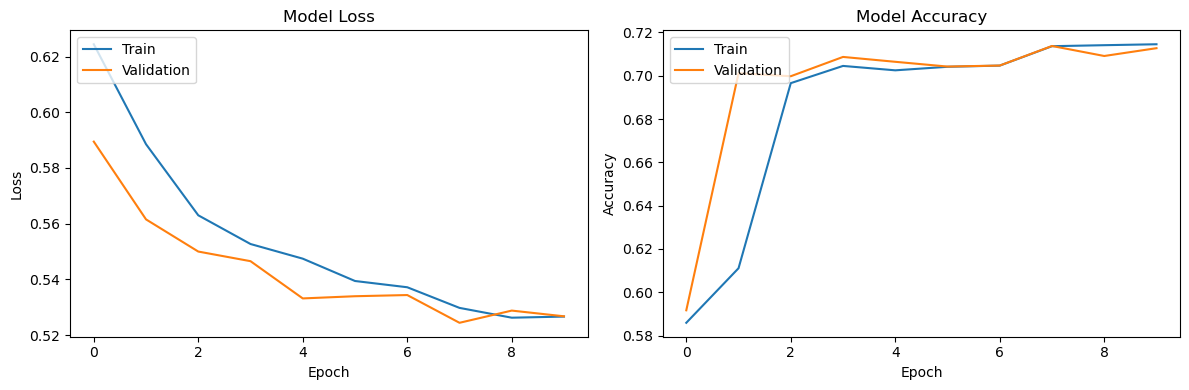

In [117]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['custom_accuracy'])  # Replace 'custom_accuracy' with the key used for your custom accuracy
plt.plot(history.history['val_custom_accuracy'])  # Replace 'val_custom_accuracy' with the key used for your custom accuracy
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()